In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties



file = './HadISST_sst.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())

longitude, latitude = dataset.variables['longitude'],dataset.variables['latitude']
time = dataset.variables['time']
sst =dataset.variables['sst']

cor_num = pd.read_excel(io = r'./ACEWP.xlsx')
coordinate = cor_num['WP'].tolist()

In [136]:
num_month = time[:].data.shape[0] # 创建空时间矩阵
num_month_1997to1982 = (1998 - 1982) * 12 #计算1982年1月到1997年12月的192月数
num_month_1998to2021 = (2022 - 1998) * 12 #计算1998年1月到2021年12月的288月数
sum_month = np.zeros(sst[:1].data[0][44:136,:].shape, dtype=float, order='C') # 创建空矩阵


In [95]:
def MeanYear(begin_month, num_month):
    # 计算年平均
    ls_mean_year = []
    if num_month % 12 != 0:
        return print("Month number must satisfiy 12!")
    else:
        for i in range(begin_month, begin_month+num_month, 12): 
            sum_month_year =  np.zeros(sst[:1].data[0][44:136,:].shape, 
                                       dtype=float, order='C')
            for month in range(12):
                tmp_month = i + month
                tmp_pre = sst[tmp_month:tmp_month+1].data[0][44:136,:]
                sum_month_year += tmp_pre
            mean_year = sum_month_year / 12
    #     mean_year = mean_year.tolist()
            ls_mean_year.append(mean_year)
    return ls_mean_year

ls_mean_1997to1982 = np.array(MeanYear(1343, num_month_1997to1982))
ls_mean_1998to2021 = np.array(MeanYear(1535, num_month_1998to2021))

In [137]:
# 对数据进行转置
reshape_mean_1997to1982 = ls_mean_1997to1982.transpose(1,2,0)
reshape_mean_1998to2021 = ls_mean_1998to2021.transpose(1,2,0)

def PearsonMatrix(reshape_mean):
    pearson_matrix = np.zeros((92,360), dtype=float, order='C')
    p_value = np.zeros((92,360), dtype=float, order='C')
    for i in range(len(reshape_mean)):
        for j in range(len(reshape_mean[i])):
            x = reshape_mean[i][j]
            if len(x) == 16:
                y = coordinate[:16]
            elif len(x) == 24:
                y = coordinate[16:]
            else:
                print("Error, the dimension x and y ")
            tmp_correlation, _ = pearsonr(x, y)
    #         print(tmp_correlation)
            pearson_matrix[i][j] = tmp_correlation
            p_value[i][j] = _
    pearson_matrix = np.nan_to_num(pearson_matrix)
    return pearson_matrix, p_value

pearson_matrix_1997to1982, p_value_1997to1982 = PearsonMatrix(reshape_mean_1997to1982)
pearson_matrix_1998to2021, p_value_1998to2021 = PearsonMatrix(reshape_mean_1998to2021)

/home/lk/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [98]:
print(pearson_matrix_1997to1982.max(), pearson_matrix_1997to1982.min())
print(pearson_matrix_1998to2021.max(), pearson_matrix_1998to2021.min())

0.8657360821515576 -0.6684429054578136
0.6615454903009607 -0.797689875469969


In [134]:
pearson_matrix_1997to1982.shape

(92, 360)

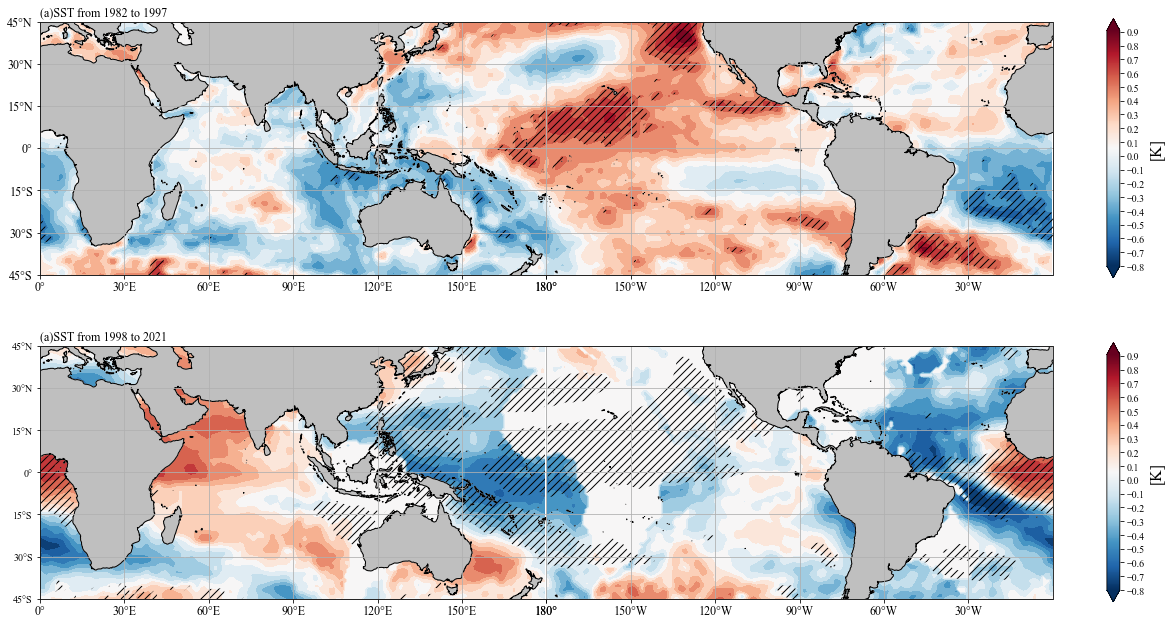

In [138]:
plt.rc('font',family='Times New Roman') 
lon = longitude[:].data
lat = latitude[44:136].data

data_1997to1982 = pearson_matrix_1997to1982 

# 调整经纬度 向东偏移180
lon_pacific_1997to1982 = lon[:] + 180
a, b = np.hsplit(data_1997to1982, [179])
data_1997to1982 = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据

#设置填色图投影方式，以及地图边界
proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181, -45,45)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
#建立画布
fig = plt.figure(figsize=(15,15))
# 添加第一个子图
fig_ax1 = fig.add_axes([0, 0.3, 1, 1], projection = proj)

fig_ax1.contourf(lon, lat, p_value_1997to1982,
            [np.nanmin(p_value_1997to1982), 0.05, np.nanmax(p_value_1997to1982)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a)SST from 1982 to 1997',loc='left',fontsize =12)

cont_ax1 = fig_ax1.contourf(lon_pacific_1997to1982, lat, data_1997to1982, 
                 levels=np.arange(-0.80, 0.91, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

fc1=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 orientation='vertical',
                 ticks=np.arange(-0.80, 0.91, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }
fc1.set_label(label="[K]", fontdict=font) #设置colorbar的标签字体及其大小

# ====================子图2======================
# 调整经纬度 向东偏移180
data_1998to2021 = pearson_matrix_1998to2021
lon_pacific_1998to2021 = lon[:] + 180
c, d = np.hsplit(data_1998to2021, [179])
data_1998to2021 = np.concatenate([d, c], axis=1) # 转换为以太平洋为中心的数据

fig_ax2 = fig.add_axes([0, 0, 1, 1], projection = proj)

fig_ax2.contourf(lon, lat, p_value_1998to2021,
            [np.nanmin(p_value_1998to2021), 0.05, np.nanmax(p_value_1998to2021)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(a)SST from 1998 to 2021',loc='left',fontsize =12)
cont_ax2 = fig_ax2.contourf(lon, lat, data_1998to2021, 
                 levels=np.arange(-0.80, 0.91, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

norm = colors.Normalize(vmin=-0.80, vmax=0.91)    #确定colormap的最大最小值

fc2=fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
                 orientation='vertical',
                 ticks=np.arange(-0.80, 0.91, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 

fc2.set_label(label="[K]", fontdict=font) #设置colorbar的标签字体及其大小


plt.savefig("sst_correl_2phase.png",dpi=300,bbox_inches='tight')

plt.show()

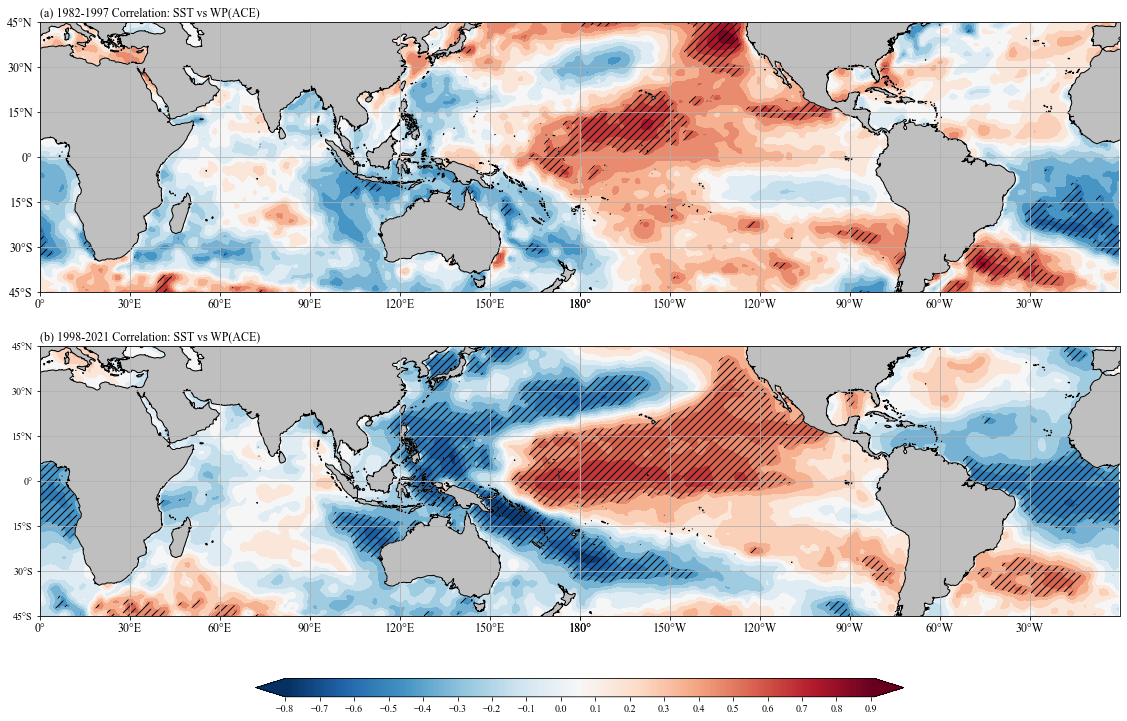

In [152]:
plt.rc('font',family='Times New Roman') 
lon = longitude[:].data
lat = latitude[44:136].data

data_1997to1982 = pearson_matrix_1997to1982 

# 调整经纬度 向东偏移180
lon_pacific_1997to1982 = lon[:] + 180
a, b = np.hsplit(data_1997to1982, [179])
data_1997to1982 = np.concatenate([b, a], axis=1) # 转换为以太平洋为中心的数据

#设置填色图投影方式，以及地图边界
proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (-180, 181, -45,45)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
#建立画布
fig = plt.figure(figsize=(15,15))
# 添加第一个子图
fig_ax1 = fig.add_axes([0, 0.3, 1, 1], projection = proj)

fig_ax1.contourf(lon, lat, p_value_1997to1982,
            [np.nanmin(p_value_1997to1982), 0.05, np.nanmax(p_value_1997to1982)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax1.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) 1982-1997 Correlation: SST vs WP(ACE)',loc='left',fontsize =12)

cont_ax1 = fig_ax1.contourf(lon_pacific_1997to1982, lat, data_1997to1982, 
                 levels=np.arange(-0.80, 0.91, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)


# ====================子图2======================
# 调整经纬度 向东偏移180
data_1998to2021 = pearson_matrix_1998to2021
lon_pacific_1998to2021 = lon[:] + 180
c, d = np.hsplit(data_1998to2021, [179])
data_1998to2021 = np.concatenate([d, c], axis=1) # 转换为以太平洋为中心的数据

fig_ax2 = fig.add_axes([0, 0, 1, 1], projection = proj)

fig_ax2.contourf(lon, lat, p_value_1998to2021,
            [np.nanmin(p_value_1998to2021), 0.05, np.nanmax(p_value_1998to2021)],
#                  [0.01, 0.05, np.nanmax(p_value)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(np.arange(-180,181,30), crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,46,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(b) 1998-2021 Correlation: SST vs WP(ACE)',loc='left',fontsize =12)
cont_ax2 = fig_ax2.contourf(lon_pacific_1998to2021, lat, data_1998to2021, 
                 levels=np.arange(-0.80, 0.91, 0.1),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }

norm = colors.Normalize(vmin=-0.80, vmax=0.91)    #确定colormap的最大最小值

# position = fig.add_axes([0.2, 0.68, 0.6, 0.017]) #中间位置
position = fig.add_axes([0.2, 0.3, 0.6, 0.017]) # 最下面位置

# c1 = fig_ax2.contourf(lon_pacific_1998to2021, lat, data_1998to2021, levels=np.arange(-0.9,1.0,0.1), zorder=0, extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

fc2=fig.colorbar(
                mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
#                 c1,
                 cax=position,
                 orientation='horizontal',
                 ticks=np.arange(-0.80, 0.91, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 

fc2.set_label(label="", fontdict=font) #设置colorbar的标签字体及其大小


plt.savefig("sst_correl_2phase.png",dpi=300,bbox_inches='tight')

plt.show()